In [3]:
# Regression Model Analysis for Sales Qty Prediction
# Comprehensive model comparison with hyperparameter tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, 
                           median_absolute_error, max_error, explained_variance_score)

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Advanced models
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Set random seeds for reproducibility
np.random.seed(42)
RANDOM_STATE = 42

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print(f"CatBoost version: {cb.__version__}")


All libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.3.4
XGBoost version: 3.1.1
LightGBM version: 4.6.0
CatBoost version: 1.2.8


In [4]:
# Load Training and Test Data
print("Loading training and test data...")

# Load training data (2022-2024)
train_data = pd.read_csv('chennai_1.5_5_star_monthly_data.csv')
print(f"Training data shape: {train_data.shape}")

# Load test data (2025)
test_data = pd.read_csv('chennai_1.5_5_star_monthly_data_test.csv')
print(f"Test data shape: {test_data.shape}")

# Display basic information about the datasets
print("\n=== TRAINING DATA INFO ===")
print(train_data.info())
print("\n=== TRAINING DATA HEAD ===")
print(train_data.head())

print("\n=== TEST DATA INFO ===")
print(test_data.info())
print("\n=== TEST DATA HEAD ===")
print(test_data.head())

# Check for missing values
print("\n=== MISSING VALUES ===")
print("Training data missing values:")
print(train_data.isnull().sum())
print("\nTest data missing values:")
print(test_data.isnull().sum())

# Basic statistics
print("\n=== TRAINING DATA STATISTICS ===")
print(train_data.describe())


Loading training and test data...
Training data shape: (36, 9)
Test data shape: (6, 9)

=== TRAINING DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YearMonth            36 non-null     object 
 1   Sales Qty.           36 non-null     float64
 2   Max_Temp             36 non-null     float64
 3   Min_Temp             36 non-null     float64
 4   Humidity             36 non-null     float64
 5   Wind_Speed           36 non-null     float64
 6   Population_Millions  36 non-null     float64
 7   Sales_Per_Capita     36 non-null     float64
 8   Season_encoded       36 non-null     int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 2.7+ KB
None

=== TRAINING DATA HEAD ===
    YearMonth  Sales Qty.  Max_Temp  Min_Temp  Humidity  Wind_Speed  \
0  2022-01-01        17.0      30.5      24.0      84.0         9.0

=== EXPLORATORY DATA ANALYSIS ===


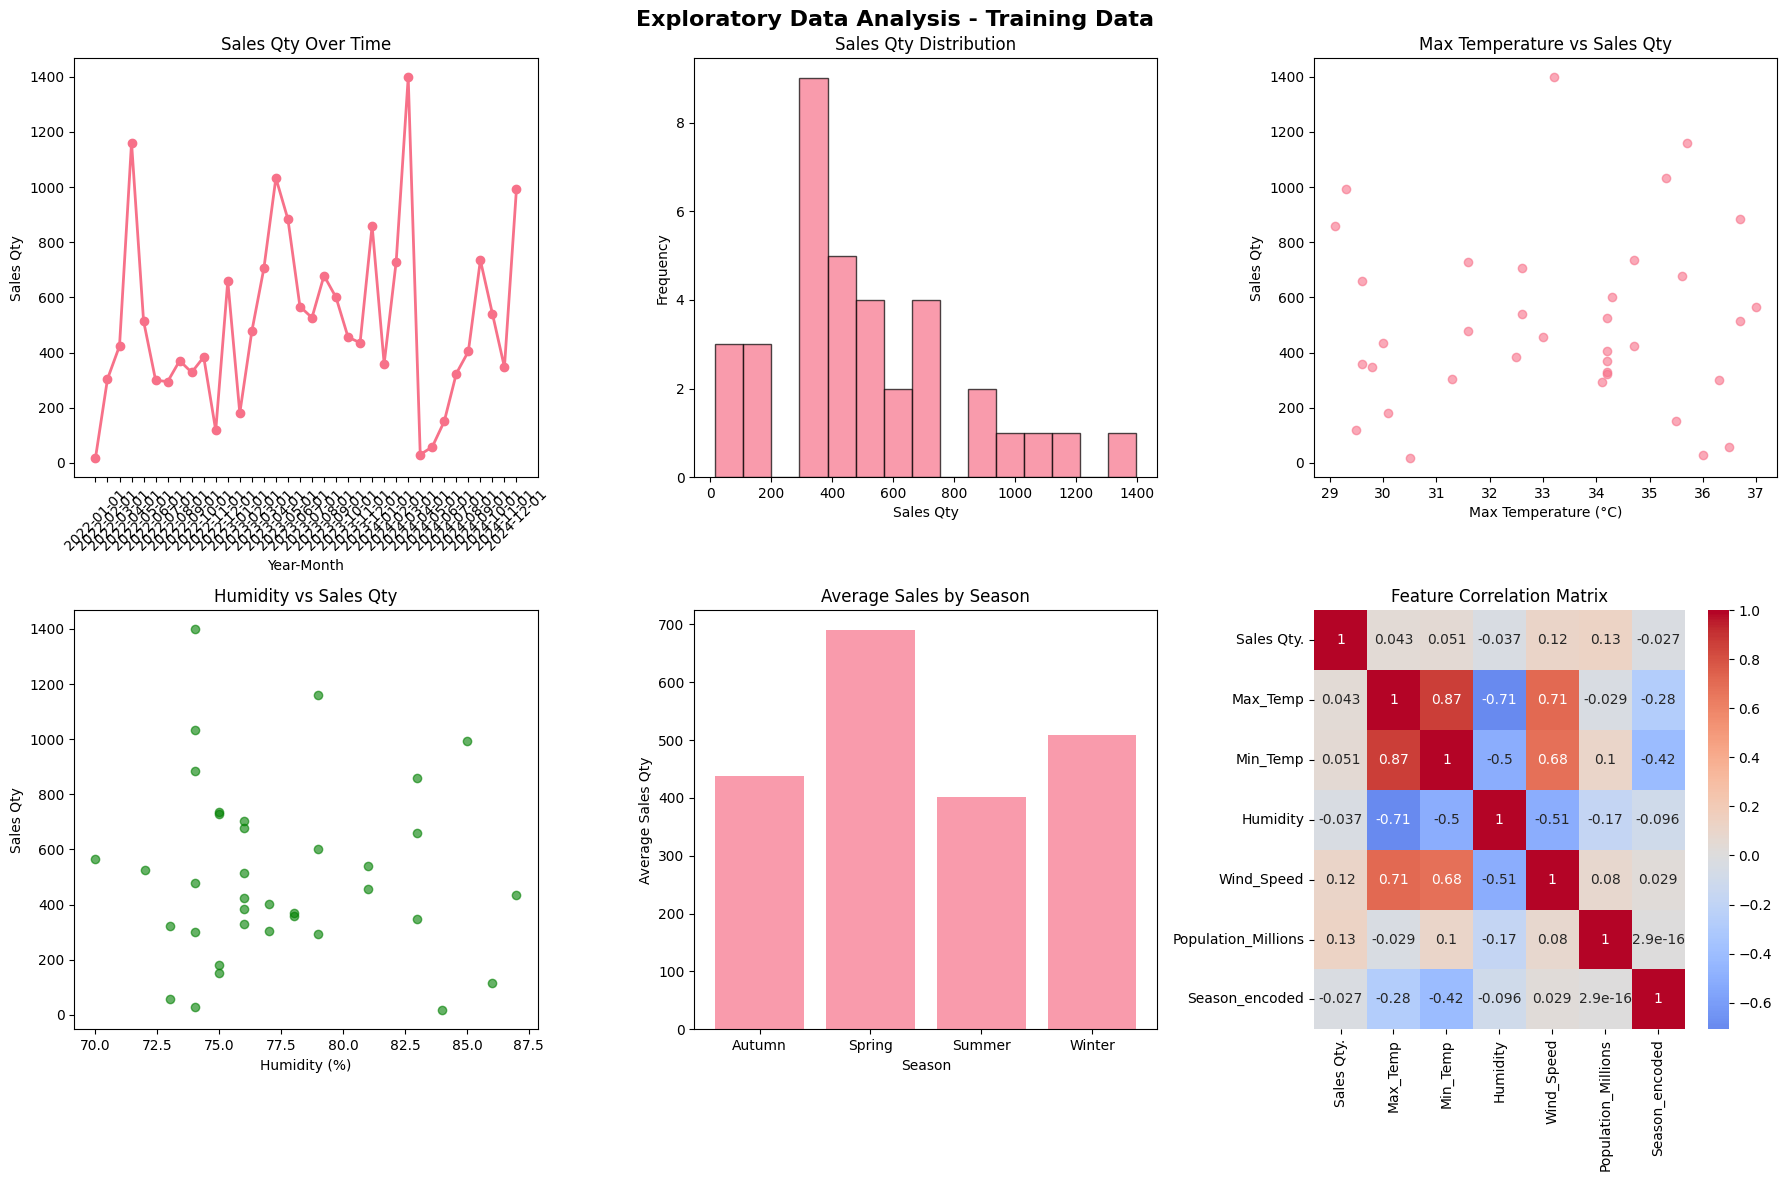


=== CORRELATION WITH SALES QTY ===
Sales Qty.             1.000000
Population_Millions    0.126748
Wind_Speed             0.115743
Min_Temp               0.050673
Max_Temp               0.043178
Season_encoded        -0.026841
Humidity              -0.037411
Name: Sales Qty., dtype: float64

=== SEASONAL ANALYSIS ===
             count        mean         std    min     max
Season_Name                                              
Autumn           9  438.222222  177.274172  117.5   735.0
Spring           9  689.722222  476.375909   30.0  1398.0
Summer           9  401.833333  162.594396  151.0   679.0
Winter           9  509.000000  325.013846   17.0   994.0


In [5]:
# Exploratory Data Analysis (EDA)
print("=== EXPLORATORY DATA ANALYSIS ===")

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create subplots for EDA
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Exploratory Data Analysis - Training Data', fontsize=16, fontweight='bold')

# 1. Sales Qty over time
axes[0, 0].plot(train_data['YearMonth'], train_data['Sales Qty.'], marker='o', linewidth=2)
axes[0, 0].set_title('Sales Qty Over Time')
axes[0, 0].set_xlabel('Year-Month')
axes[0, 0].set_ylabel('Sales Qty')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Sales Qty distribution
axes[0, 1].hist(train_data['Sales Qty.'], bins=15, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Sales Qty Distribution')
axes[0, 1].set_xlabel('Sales Qty')
axes[0, 1].set_ylabel('Frequency')

# 3. Temperature vs Sales
axes[0, 2].scatter(train_data['Max_Temp'], train_data['Sales Qty.'], alpha=0.6)
axes[0, 2].set_title('Max Temperature vs Sales Qty')
axes[0, 2].set_xlabel('Max Temperature (°C)')
axes[0, 2].set_ylabel('Sales Qty')

# 4. Humidity vs Sales
axes[1, 0].scatter(train_data['Humidity'], train_data['Sales Qty.'], alpha=0.6, color='green')
axes[1, 0].set_title('Humidity vs Sales Qty')
axes[1, 0].set_xlabel('Humidity (%)')
axes[1, 0].set_ylabel('Sales Qty')

# 5. Season vs Sales
season_names = {0: 'Autumn', 1: 'Spring', 2: 'Summer', 3: 'Winter'}
train_data['Season_Name'] = train_data['Season_encoded'].map(season_names)
season_sales = train_data.groupby('Season_Name')['Sales Qty.'].mean()
axes[1, 1].bar(season_sales.index, season_sales.values, alpha=0.7)
axes[1, 1].set_title('Average Sales by Season')
axes[1, 1].set_xlabel('Season')
axes[1, 1].set_ylabel('Average Sales Qty')

# 6. Correlation heatmap
correlation_features = ['Sales Qty.', 'Max_Temp', 'Min_Temp', 'Humidity', 'Wind_Speed', 'Population_Millions', 'Season_encoded']
corr_matrix = train_data[correlation_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
axes[1, 2].set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

# Print correlation with target
print("\n=== CORRELATION WITH SALES QTY ===")
correlations = train_data[correlation_features].corr()['Sales Qty.'].sort_values(ascending=False)
print(correlations)

# Seasonal analysis
print("\n=== SEASONAL ANALYSIS ===")
seasonal_stats = train_data.groupby('Season_Name')['Sales Qty.'].agg(['count', 'mean', 'std', 'min', 'max'])
print(seasonal_stats)


In [6]:
# Feature Engineering
print("=== FEATURE ENGINEERING ===")

def create_features(df):
    """
    Create engineered features from the dataset
    """
    df_eng = df.copy()
    
    # Convert YearMonth to datetime
    df_eng['YearMonth'] = pd.to_datetime(df_eng['YearMonth'])
    
    # Extract temporal features
    df_eng['Year'] = df_eng['YearMonth'].dt.year
    df_eng['Month'] = df_eng['YearMonth'].dt.month
    df_eng['Quarter'] = df_eng['YearMonth'].dt.quarter
    
    # Create temperature range feature
    df_eng['Temp_Range'] = df_eng['Max_Temp'] - df_eng['Min_Temp']
    
    # Create temperature average
    df_eng['Avg_Temp'] = (df_eng['Max_Temp'] + df_eng['Min_Temp']) / 2
    
    # Create weather comfort index (lower is more comfortable)
    df_eng['Weather_Comfort'] = (df_eng['Max_Temp'] * 0.3 + 
                                df_eng['Humidity'] * 0.3 + 
                                df_eng['Wind_Speed'] * 0.2 + 
                                df_eng['Temp_Range'] * 0.2)
    
    # Create population density proxy (assuming constant area)
    df_eng['Population_Density'] = df_eng['Population_Millions']  # Already in millions
    
    return df_eng

# Apply feature engineering to both datasets
print("Creating engineered features...")
train_eng = create_features(train_data)
test_eng = create_features(test_data)

# Display new features
print(f"Training data shape after feature engineering: {train_eng.shape}")
print(f"Test data shape after feature engineering: {test_eng.shape}")

# Show new columns
new_features = ['Year', 'Month', 'Quarter', 'Temp_Range', 'Avg_Temp', 'Weather_Comfort', 'Population_Density']
print(f"\nNew features created: {new_features}")

# Display sample of engineered data
print("\n=== ENGINEERED FEATURES SAMPLE ===")
print(train_eng[['YearMonth', 'Sales Qty.', 'Max_Temp', 'Min_Temp', 'Temp_Range', 'Avg_Temp', 'Weather_Comfort']].head())

# Check for any infinite or NaN values in new features
print("\n=== CHECKING FOR DATA QUALITY ISSUES ===")
for feature in new_features:
    if feature in train_eng.columns:
        inf_count = np.isinf(train_eng[feature]).sum()
        nan_count = train_eng[feature].isnull().sum()
        print(f"{feature}: {inf_count} infinite values, {nan_count} NaN values")


=== FEATURE ENGINEERING ===
Creating engineered features...
Training data shape after feature engineering: (36, 17)
Test data shape after feature engineering: (6, 16)

New features created: ['Year', 'Month', 'Quarter', 'Temp_Range', 'Avg_Temp', 'Weather_Comfort', 'Population_Density']

=== ENGINEERED FEATURES SAMPLE ===
   YearMonth  Sales Qty.  Max_Temp  Min_Temp  Temp_Range  Avg_Temp  \
0 2022-01-01        17.0      30.5      24.0         6.5     27.25   
1 2022-02-01       304.0      31.3      24.0         7.3     27.65   
2 2022-03-01       424.0      34.7      26.0         8.7     30.35   
3 2022-04-01      1161.5      35.7      28.0         7.7     31.85   
4 2022-05-01       514.5      36.7      27.0         9.7     31.85   

   Weather_Comfort  
0            37.45  
1            36.15  
2            37.35  
3            38.55  
4            38.75  

=== CHECKING FOR DATA QUALITY ISSUES ===
Year: 0 infinite values, 0 NaN values
Month: 0 infinite values, 0 NaN values
Quarter: 0 i

In [7]:
# Prepare Features and Target Variables
print("=== PREPARING FEATURES AND TARGET ===")

# Define features to use (excluding Sales_Per_Capita to avoid data leakage)
base_features = ['Max_Temp', 'Min_Temp', 'Humidity', 'Wind_Speed', 'Population_Millions', 'Season_encoded']
engineered_features = ['Year', 'Month', 'Quarter', 'Temp_Range', 'Avg_Temp', 'Weather_Comfort', 'Population_Density']

# Combine all features
all_features = base_features + engineered_features

print(f"Base features: {base_features}")
print(f"Engineered features: {engineered_features}")
print(f"Total features: {len(all_features)}")

# Prepare training data
X_train_base = train_eng[base_features].values
X_train_eng = train_eng[all_features].values
y_train = train_eng['Sales Qty.'].values

# Prepare test data
X_test_base = test_eng[base_features].values
X_test_eng = test_eng[all_features].values
y_test = test_eng['Sales Qty.'].values

print(f"\nTraining data shapes:")
print(f"X_train_base: {X_train_base.shape}")
print(f"X_train_eng: {X_train_eng.shape}")
print(f"y_train: {y_train.shape}")

print(f"\nTest data shapes:")
print(f"X_test_base: {X_test_base.shape}")
print(f"X_test_eng: {X_test_eng.shape}")
print(f"y_test: {y_test.shape}")

# Create feature names for reference
feature_names_base = base_features
feature_names_eng = all_features

print(f"\nFeature names (base): {feature_names_base}")
print(f"Feature names (engineered): {feature_names_eng}")

# Check for any missing values
print(f"\n=== DATA QUALITY CHECK ===")
print(f"Training data missing values: {np.isnan(X_train_eng).sum()}")
print(f"Test data missing values: {np.isnan(X_test_eng).sum()}")
print(f"Target missing values (train): {np.isnan(y_train).sum()}")
print(f"Target missing values (test): {np.isnan(y_test).sum()}")

# Display target variable statistics
print(f"\n=== TARGET VARIABLE STATISTICS ===")
print(f"Training target - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Training target - Min: {y_train.min():.2f}, Max: {y_train.max():.2f}")
print(f"Test target - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")
print(f"Test target - Min: {y_test.min():.2f}, Max: {y_test.max():.2f}")


=== PREPARING FEATURES AND TARGET ===
Base features: ['Max_Temp', 'Min_Temp', 'Humidity', 'Wind_Speed', 'Population_Millions', 'Season_encoded']
Engineered features: ['Year', 'Month', 'Quarter', 'Temp_Range', 'Avg_Temp', 'Weather_Comfort', 'Population_Density']
Total features: 13

Training data shapes:
X_train_base: (36, 6)
X_train_eng: (36, 13)
y_train: (36,)

Test data shapes:
X_test_base: (6, 6)
X_test_eng: (6, 13)
y_test: (6,)

Feature names (base): ['Max_Temp', 'Min_Temp', 'Humidity', 'Wind_Speed', 'Population_Millions', 'Season_encoded']
Feature names (engineered): ['Max_Temp', 'Min_Temp', 'Humidity', 'Wind_Speed', 'Population_Millions', 'Season_encoded', 'Year', 'Month', 'Quarter', 'Temp_Range', 'Avg_Temp', 'Weather_Comfort', 'Population_Density']

=== DATA QUALITY CHECK ===
Training data missing values: 0
Test data missing values: 0
Target missing values (train): 0
Target missing values (test): 0

=== TARGET VARIABLE STATISTICS ===
Training target - Mean: 509.69, Std: 314.72
Tr

In [8]:
# Preprocessing and Scaling
print("=== PREPROCESSING AND SCALING ===")

# Create scalers for both base and engineered features
scaler_base = StandardScaler()
scaler_eng = StandardScaler()

# Fit and transform training data
X_train_base_scaled = scaler_base.fit_transform(X_train_base)
X_train_eng_scaled = scaler_eng.fit_transform(X_train_eng)

# Transform test data using fitted scalers
X_test_base_scaled = scaler_base.transform(X_test_base)
X_test_eng_scaled = scaler_eng.transform(X_test_eng)

print("Data scaling completed successfully!")
print(f"Scaled training data shapes:")
print(f"X_train_base_scaled: {X_train_base_scaled.shape}")
print(f"X_train_eng_scaled: {X_train_eng_scaled.shape}")

print(f"\nScaled test data shapes:")
print(f"X_test_base_scaled: {X_test_base_scaled.shape}")
print(f"X_test_eng_scaled: {X_test_eng_scaled.shape}")

# Verify scaling worked correctly
print(f"\n=== SCALING VERIFICATION ===")
print(f"Base features - Mean: {X_train_base_scaled.mean(axis=0).round(3)}")
print(f"Base features - Std: {X_train_base_scaled.std(axis=0).round(3)}")
print(f"Engineered features - Mean: {X_train_eng_scaled.mean(axis=0).round(3)}")
print(f"Engineered features - Std: {X_train_eng_scaled.std(axis=0).round(3)}")

# Create polynomial features for comparison
print(f"\n=== CREATING POLYNOMIAL FEATURES ===")
poly_features = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

# Create polynomial features for base features only (to avoid overfitting with small dataset)
X_train_poly = poly_features.fit_transform(X_train_base_scaled)
X_test_poly = poly_features.transform(X_test_base_scaled)

print(f"Polynomial features shape: {X_train_poly.shape}")
print(f"Number of polynomial features: {X_train_poly.shape[1]}")

# Get polynomial feature names
poly_feature_names = poly_features.get_feature_names_out(feature_names_base)
print(f"Polynomial feature names: {poly_feature_names}")

# Summary of all feature sets
print(f"\n=== FEATURE SETS SUMMARY ===")
print(f"1. Base features: {X_train_base_scaled.shape[1]} features")
print(f"2. Engineered features: {X_train_eng_scaled.shape[1]} features") 
print(f"3. Polynomial features: {X_train_poly.shape[1]} features")

# We'll test all three feature sets in our models
feature_sets = {
    'base': (X_train_base_scaled, X_test_base_scaled, feature_names_base),
    'engineered': (X_train_eng_scaled, X_test_eng_scaled, feature_names_eng),
    'polynomial': (X_train_poly, X_test_poly, poly_feature_names)
}


=== PREPROCESSING AND SCALING ===
Data scaling completed successfully!
Scaled training data shapes:
X_train_base_scaled: (36, 6)
X_train_eng_scaled: (36, 13)

Scaled test data shapes:
X_test_base_scaled: (6, 6)
X_test_eng_scaled: (6, 13)

=== SCALING VERIFICATION ===
Base features - Mean: [0. 0. 0. 0. 0. 0.]
Base features - Std: [1. 1. 1. 1. 1. 1.]
Engineered features - Mean: [ 0.  0.  0.  0.  0.  0.  0. -0.  0. -0. -0.  0.  0.]
Engineered features - Std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

=== CREATING POLYNOMIAL FEATURES ===
Polynomial features shape: (36, 27)
Number of polynomial features: 27
Polynomial feature names: ['Max_Temp' 'Min_Temp' 'Humidity' 'Wind_Speed' 'Population_Millions'
 'Season_encoded' 'Max_Temp^2' 'Max_Temp Min_Temp' 'Max_Temp Humidity'
 'Max_Temp Wind_Speed' 'Max_Temp Population_Millions'
 'Max_Temp Season_encoded' 'Min_Temp^2' 'Min_Temp Humidity'
 'Min_Temp Wind_Speed' 'Min_Temp Population_Millions'
 'Min_Temp Season_encoded' 'Humidity^2' 'Humidity Wind_Sp

In [9]:
# Define Models and Hyperparameter Grids
print("=== DEFINING MODELS AND HYPERPARAMETER GRIDS ===")

# Define all models with their hyperparameter grids
models_config = {
    'LinearRegression': {
        'model': LinearRegression(),
        'grid_params': {},
        'random_params': {}
    },
    
    'Ridge': {
        'model': Ridge(random_state=RANDOM_STATE),
        'grid_params': {
            'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
        },
        'random_params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
        }
    },
    
    'Lasso': {
        'model': Lasso(random_state=RANDOM_STATE, max_iter=2000),
        'grid_params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        },
        'random_params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        }
    },
    
    'ElasticNet': {
        'model': ElasticNet(random_state=RANDOM_STATE, max_iter=2000),
        'grid_params': {
            'alpha': [0.01, 0.1, 1.0, 10.0],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        },
        'random_params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
            'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        }
    },
    
    'SVR': {
        'model': SVR(),
        'grid_params': {
            'C': [0.1, 1.0, 10.0, 100.0],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1.0],
            'kernel': ['rbf', 'linear', 'poly']
        },
        'random_params': {
            'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
            'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
            'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
        }
    },
    
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(random_state=RANDOM_STATE),
        'grid_params': {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8]
        },
        'random_params': {
            'max_depth': [3, 5, 7, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10, 15, 20, 25],
            'min_samples_leaf': [1, 2, 4, 6, 8, 10],
            'max_features': ['auto', 'sqrt', 'log2', None]
        }
    },
    
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        'grid_params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'random_params': {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10, 15, 20],
            'min_samples_leaf': [1, 2, 4, 6, 8],
            'max_features': ['auto', 'sqrt', 'log2', None]
        }
    },
    
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=RANDOM_STATE),
        'grid_params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        },
        'random_params': {
            'n_estimators': [50, 100, 200, 300, 500],
            'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
            'max_depth': [3, 5, 7, 9, 11],
            'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
            'max_features': ['auto', 'sqrt', 'log2', None]
        }
    },
    
    'XGBRegressor': {
        'model': xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        'grid_params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        },
        'random_params': {
            'n_estimators': [50, 100, 200, 300, 500],
            'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
            'max_depth': [3, 5, 7, 9, 11],
            'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
        }
    },
    
    'LGBMRegressor': {
        'model': lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
        'grid_params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        },
        'random_params': {
            'n_estimators': [50, 100, 200, 300, 500],
            'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
            'max_depth': [3, 5, 7, 9, 11],
            'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
        }
    },
    
    'CatBoostRegressor': {
        'model': cb.CatBoostRegressor(random_state=RANDOM_STATE, verbose=False),
        'grid_params': {
            'iterations': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        },
        'random_params': {
            'iterations': [50, 100, 200, 300, 500],
            'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
            'depth': [3, 5, 7, 9, 11],
            'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
        }
    },
    
    'MLPRegressor': {
        'model': MLPRegressor(random_state=RANDOM_STATE, max_iter=1000),
        'grid_params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive']
        },
        'random_params': {
            'hidden_layer_sizes': [(25,), (50,), (100,), (50, 25), (100, 50), (50, 50), (100, 100)],
            'activation': ['relu', 'tanh', 'logistic'],
            'alpha': [0.0001, 0.001, 0.01, 0.1],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'learning_rate_init': [0.001, 0.01, 0.1]
        }
    }
}

print(f"Defined {len(models_config)} models:")
for model_name in models_config.keys():
    print(f"- {model_name}")

print(f"\nModels will be tested with:")
print(f"- Default parameters")
print(f"- GridSearchCV (5-fold cross-validation)")
print(f"- RandomizedSearchCV (5-fold cross-validation, 50 iterations)")
print(f"- Three feature sets: base, engineered, polynomial")


=== DEFINING MODELS AND HYPERPARAMETER GRIDS ===
Defined 12 models:
- LinearRegression
- Ridge
- Lasso
- ElasticNet
- SVR
- DecisionTreeRegressor
- RandomForestRegressor
- GradientBoostingRegressor
- XGBRegressor
- LGBMRegressor
- CatBoostRegressor
- MLPRegressor

Models will be tested with:
- Default parameters
- GridSearchCV (5-fold cross-validation)
- RandomizedSearchCV (5-fold cross-validation, 50 iterations)
- Three feature sets: base, engineered, polynomial


In [10]:
# Model Training and Evaluation Functions
print("=== SETTING UP TRAINING AND EVALUATION FUNCTIONS ===")

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive regression metrics"""
    # Avoid division by zero in MAPE calculation
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MAPE': mape,
        'MedAE': median_absolute_error(y_true, y_pred),
        'Max_Error': max_error(y_true, y_pred),
        'Explained_Variance': explained_variance_score(y_true, y_pred)
    }

def train_and_evaluate_model(model, model_name, feature_set_name, X_train, X_test, y_train, y_test, 
                           grid_params=None, random_params=None):
    """Train and evaluate a model with different hyperparameter tuning methods"""
    results = []
    
    # 1. Default parameters
    print(f"  Training {model_name} with default parameters...")
    start_time = datetime.now()
    
    model_default = model.__class__(**model.get_params())
    model_default.fit(X_train, y_train)
    y_pred_default = model_default.predict(X_test)
    
    default_metrics = calculate_metrics(y_test, y_pred_default)
    default_metrics.update({
        'Model': model_name,
        'Feature_Set': feature_set_name,
        'Tuning_Method': 'Default',
        'Training_Time': (datetime.now() - start_time).total_seconds(),
        'Best_Params': 'Default'
    })
    results.append(default_metrics)
    
    # 2. GridSearchCV (if parameters provided)
    if grid_params:
        print(f"  Training {model_name} with GridSearchCV...")
        start_time = datetime.now()
        
        grid_search = GridSearchCV(
            model, grid_params, cv=5, scoring='neg_mean_squared_error', 
            n_jobs=-1, random_state=RANDOM_STATE
        )
        grid_search.fit(X_train, y_train)
        y_pred_grid = grid_search.predict(X_test)
        
        grid_metrics = calculate_metrics(y_test, y_pred_grid)
        grid_metrics.update({
            'Model': model_name,
            'Feature_Set': feature_set_name,
            'Tuning_Method': 'GridSearch',
            'Training_Time': (datetime.now() - start_time).total_seconds(),
            'Best_Params': str(grid_search.best_params_)
        })
        results.append(grid_metrics)
    
    # 3. RandomizedSearchCV (if parameters provided)
    if random_params:
        print(f"  Training {model_name} with RandomizedSearchCV...")
        start_time = datetime.now()
        
        random_search = RandomizedSearchCV(
            model, random_params, n_iter=50, cv=5, scoring='neg_mean_squared_error',
            n_jobs=-1, random_state=RANDOM_STATE
        )
        random_search.fit(X_train, y_train)
        y_pred_random = random_search.predict(X_test)
        
        random_metrics = calculate_metrics(y_test, y_pred_random)
        random_metrics.update({
            'Model': model_name,
            'Feature_Set': feature_set_name,
            'Tuning_Method': 'RandomSearch',
            'Training_Time': (datetime.now() - start_time).total_seconds(),
            'Best_Params': str(random_search.best_params_)
        })
        results.append(random_metrics)
    
    return results

print("Training and evaluation functions defined successfully!")
print("Functions include:")
print("- calculate_metrics(): Computes RMSE, MAE, R², MAPE, MedAE, Max Error, Explained Variance")
print("- train_and_evaluate_model(): Trains models with default, GridSearch, and RandomSearch methods")


=== SETTING UP TRAINING AND EVALUATION FUNCTIONS ===
Training and evaluation functions defined successfully!
Functions include:
- calculate_metrics(): Computes RMSE, MAE, R², MAPE, MedAE, Max Error, Explained Variance
- train_and_evaluate_model(): Trains models with default, GridSearch, and RandomSearch methods


In [11]:
# Main Training Loop - Kitchen Sink Approach
print("=== STARTING COMPREHENSIVE MODEL TRAINING ===")
print("This will train all models with all feature sets and tuning methods...")
print("Total combinations: 12 models × 3 feature sets × 3 tuning methods = 108 combinations")
print("This may take several minutes to complete...\n")

# Store all results
all_results = []
total_combinations = len(models_config) * len(feature_sets) * 3  # 3 tuning methods
current_combination = 0

# Start timing
overall_start_time = datetime.now()

# Loop through all models
for model_name, model_config in models_config.items():
    print(f"\n{'='*60}")
    print(f"TRAINING MODEL: {model_name}")
    print(f"{'='*60}")
    
    model = model_config['model']
    grid_params = model_config['grid_params']
    random_params = model_config['random_params']
    
    # Loop through all feature sets
    for feature_set_name, (X_train, X_test, feature_names) in feature_sets.items():
        print(f"\n--- Feature Set: {feature_set_name} ({X_train.shape[1]} features) ---")
        
        # Train and evaluate the model
        try:
            model_results = train_and_evaluate_model(
                model, model_name, feature_set_name, 
                X_train, X_test, y_train, y_test,
                grid_params, random_params
            )
            all_results.extend(model_results)
            current_combination += len(model_results)
            
            print(f"  ✓ Completed {len(model_results)} tuning methods")
            print(f"  Progress: {current_combination}/{total_combinations} combinations")
            
        except Exception as e:
            print(f"  ✗ Error training {model_name} with {feature_set_name}: {str(e)}")
            continue

# Calculate total time
total_time = datetime.now() - overall_start_time
print(f"\n{'='*60}")
print(f"TRAINING COMPLETED!")
print(f"Total time: {total_time}")
print(f"Total results: {len(all_results)}")
print(f"{'='*60}")

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

print(f"\nResults DataFrame shape: {results_df.shape}")
print(f"Columns: {list(results_df.columns)}")
print(f"\nFirst few results:")
print(results_df.head())


=== STARTING COMPREHENSIVE MODEL TRAINING ===
This will train all models with all feature sets and tuning methods...
Total combinations: 12 models × 3 feature sets × 3 tuning methods = 108 combinations
This may take several minutes to complete...


TRAINING MODEL: LinearRegression

--- Feature Set: base (6 features) ---
  Training LinearRegression with default parameters...
  ✓ Completed 1 tuning methods
  Progress: 1/108 combinations

--- Feature Set: engineered (13 features) ---
  Training LinearRegression with default parameters...
  ✓ Completed 1 tuning methods
  Progress: 2/108 combinations

--- Feature Set: polynomial (27 features) ---
  Training LinearRegression with default parameters...
  ✓ Completed 1 tuning methods
  Progress: 3/108 combinations

TRAINING MODEL: Ridge

--- Feature Set: base (6 features) ---
  Training Ridge with default parameters...
  Training Ridge with GridSearchCV...
  ✗ Error training Ridge with base: GridSearchCV.__init__() got an unexpected keyword ar

In [12]:
# Results Analysis and Model Comparison
print("=== RESULTS ANALYSIS ===")

# Display comprehensive results
print(f"Total experiments completed: {len(results_df)}")
print(f"Unique models tested: {results_df['Model'].nunique()}")
print(f"Feature sets tested: {results_df['Feature_Set'].unique()}")
print(f"Tuning methods tested: {results_df['Tuning_Method'].unique()}")

# Sort by RMSE (lower is better)
results_sorted = results_df.sort_values('RMSE').reset_index(drop=True)

print(f"\n=== TOP 10 BEST MODELS (by RMSE) ===")
top_10 = results_sorted.head(10)
for idx, row in top_10.iterrows():
    print(f"{idx+1:2d}. {row['Model']:20s} | {row['Feature_Set']:12s} | {row['Tuning_Method']:12s} | RMSE: {row['RMSE']:8.2f} | R²: {row['R2']:6.3f}")

# Best model overall
best_model = results_sorted.iloc[0]
print(f"\n=== BEST MODEL OVERALL ===")
print(f"Model: {best_model['Model']}")
print(f"Feature Set: {best_model['Feature_Set']}")
print(f"Tuning Method: {best_model['Tuning_Method']}")
print(f"RMSE: {best_model['RMSE']:.2f}")
print(f"MAE: {best_model['MAE']:.2f}")
print(f"R²: {best_model['R2']:.3f}")
print(f"MAPE: {best_model['MAPE']:.1f}%")
print(f"Training Time: {best_model['Training_Time']:.2f} seconds")
print(f"Best Parameters: {best_model['Best_Params']}")

# Analysis by different criteria
print(f"\n=== ANALYSIS BY DIFFERENT METRICS ===")

# Best by R²
best_r2 = results_df.loc[results_df['R2'].idxmax()]
print(f"Best R²: {best_r2['Model']} ({best_r2['Feature_Set']}, {best_r2['Tuning_Method']}) - R²: {best_r2['R2']:.3f}")

# Best by MAE
best_mae = results_df.loc[results_df['MAE'].idxmin()]
print(f"Best MAE: {best_mae['Model']} ({best_mae['Feature_Set']}, {best_mae['Tuning_Method']}) - MAE: {best_mae['MAE']:.2f}")

# Best by MAPE
best_mape = results_df.loc[results_df['MAPE'].idxmin()]
print(f"Best MAPE: {best_mape['Model']} ({best_mape['Feature_Set']}, {best_mape['Tuning_Method']}) - MAPE: {best_mape['MAPE']:.1f}%")

# Fastest training
fastest = results_df.loc[results_df['Training_Time'].idxmin()]
print(f"Fastest Training: {fastest['Model']} ({fastest['Feature_Set']}, {fastest['Tuning_Method']}) - Time: {fastest['Training_Time']:.2f}s")

# Analysis by feature sets
print(f"\n=== PERFORMANCE BY FEATURE SET ===")
feature_performance = results_df.groupby('Feature_Set').agg({
    'RMSE': 'mean',
    'R2': 'mean',
    'MAE': 'mean',
    'MAPE': 'mean'
}).round(3)
print(feature_performance)

# Analysis by tuning method
print(f"\n=== PERFORMANCE BY TUNING METHOD ===")
tuning_performance = results_df.groupby('Tuning_Method').agg({
    'RMSE': 'mean',
    'R2': 'mean',
    'MAE': 'mean',
    'MAPE': 'mean',
    'Training_Time': 'mean'
}).round(3)
print(tuning_performance)

# Analysis by model type
print(f"\n=== PERFORMANCE BY MODEL TYPE ===")
model_performance = results_df.groupby('Model').agg({
    'RMSE': 'mean',
    'R2': 'mean',
    'MAE': 'mean',
    'MAPE': 'mean',
    'Training_Time': 'mean'
}).round(3).sort_values('RMSE')
print(model_performance)


=== RESULTS ANALYSIS ===
Total experiments completed: 3
Unique models tested: 1
Feature sets tested: ['base' 'engineered' 'polynomial']
Tuning methods tested: ['Default']

=== TOP 10 BEST MODELS (by RMSE) ===
 1. LinearRegression     | base         | Default      | RMSE:   335.29 | R²: -0.153
 2. LinearRegression     | engineered   | Default      | RMSE:   438.11 | R²: -0.969
 3. LinearRegression     | polynomial   | Default      | RMSE:   643.73 | R²: -3.251

=== BEST MODEL OVERALL ===
Model: LinearRegression
Feature Set: base
Tuning Method: Default
RMSE: 335.29
MAE: 284.01
R²: -0.153
MAPE: 61.6%
Training Time: 0.00 seconds
Best Parameters: Default

=== ANALYSIS BY DIFFERENT METRICS ===
Best R²: LinearRegression (base, Default) - R²: -0.153
Best MAE: LinearRegression (base, Default) - MAE: 284.01
Best MAPE: LinearRegression (engineered, Default) - MAPE: 57.1%
Fastest Training: LinearRegression (engineered, Default) - Time: 0.00s

=== PERFORMANCE BY FEATURE SET ===
                RMSE

=== CREATING COMPREHENSIVE VISUALIZATIONS ===


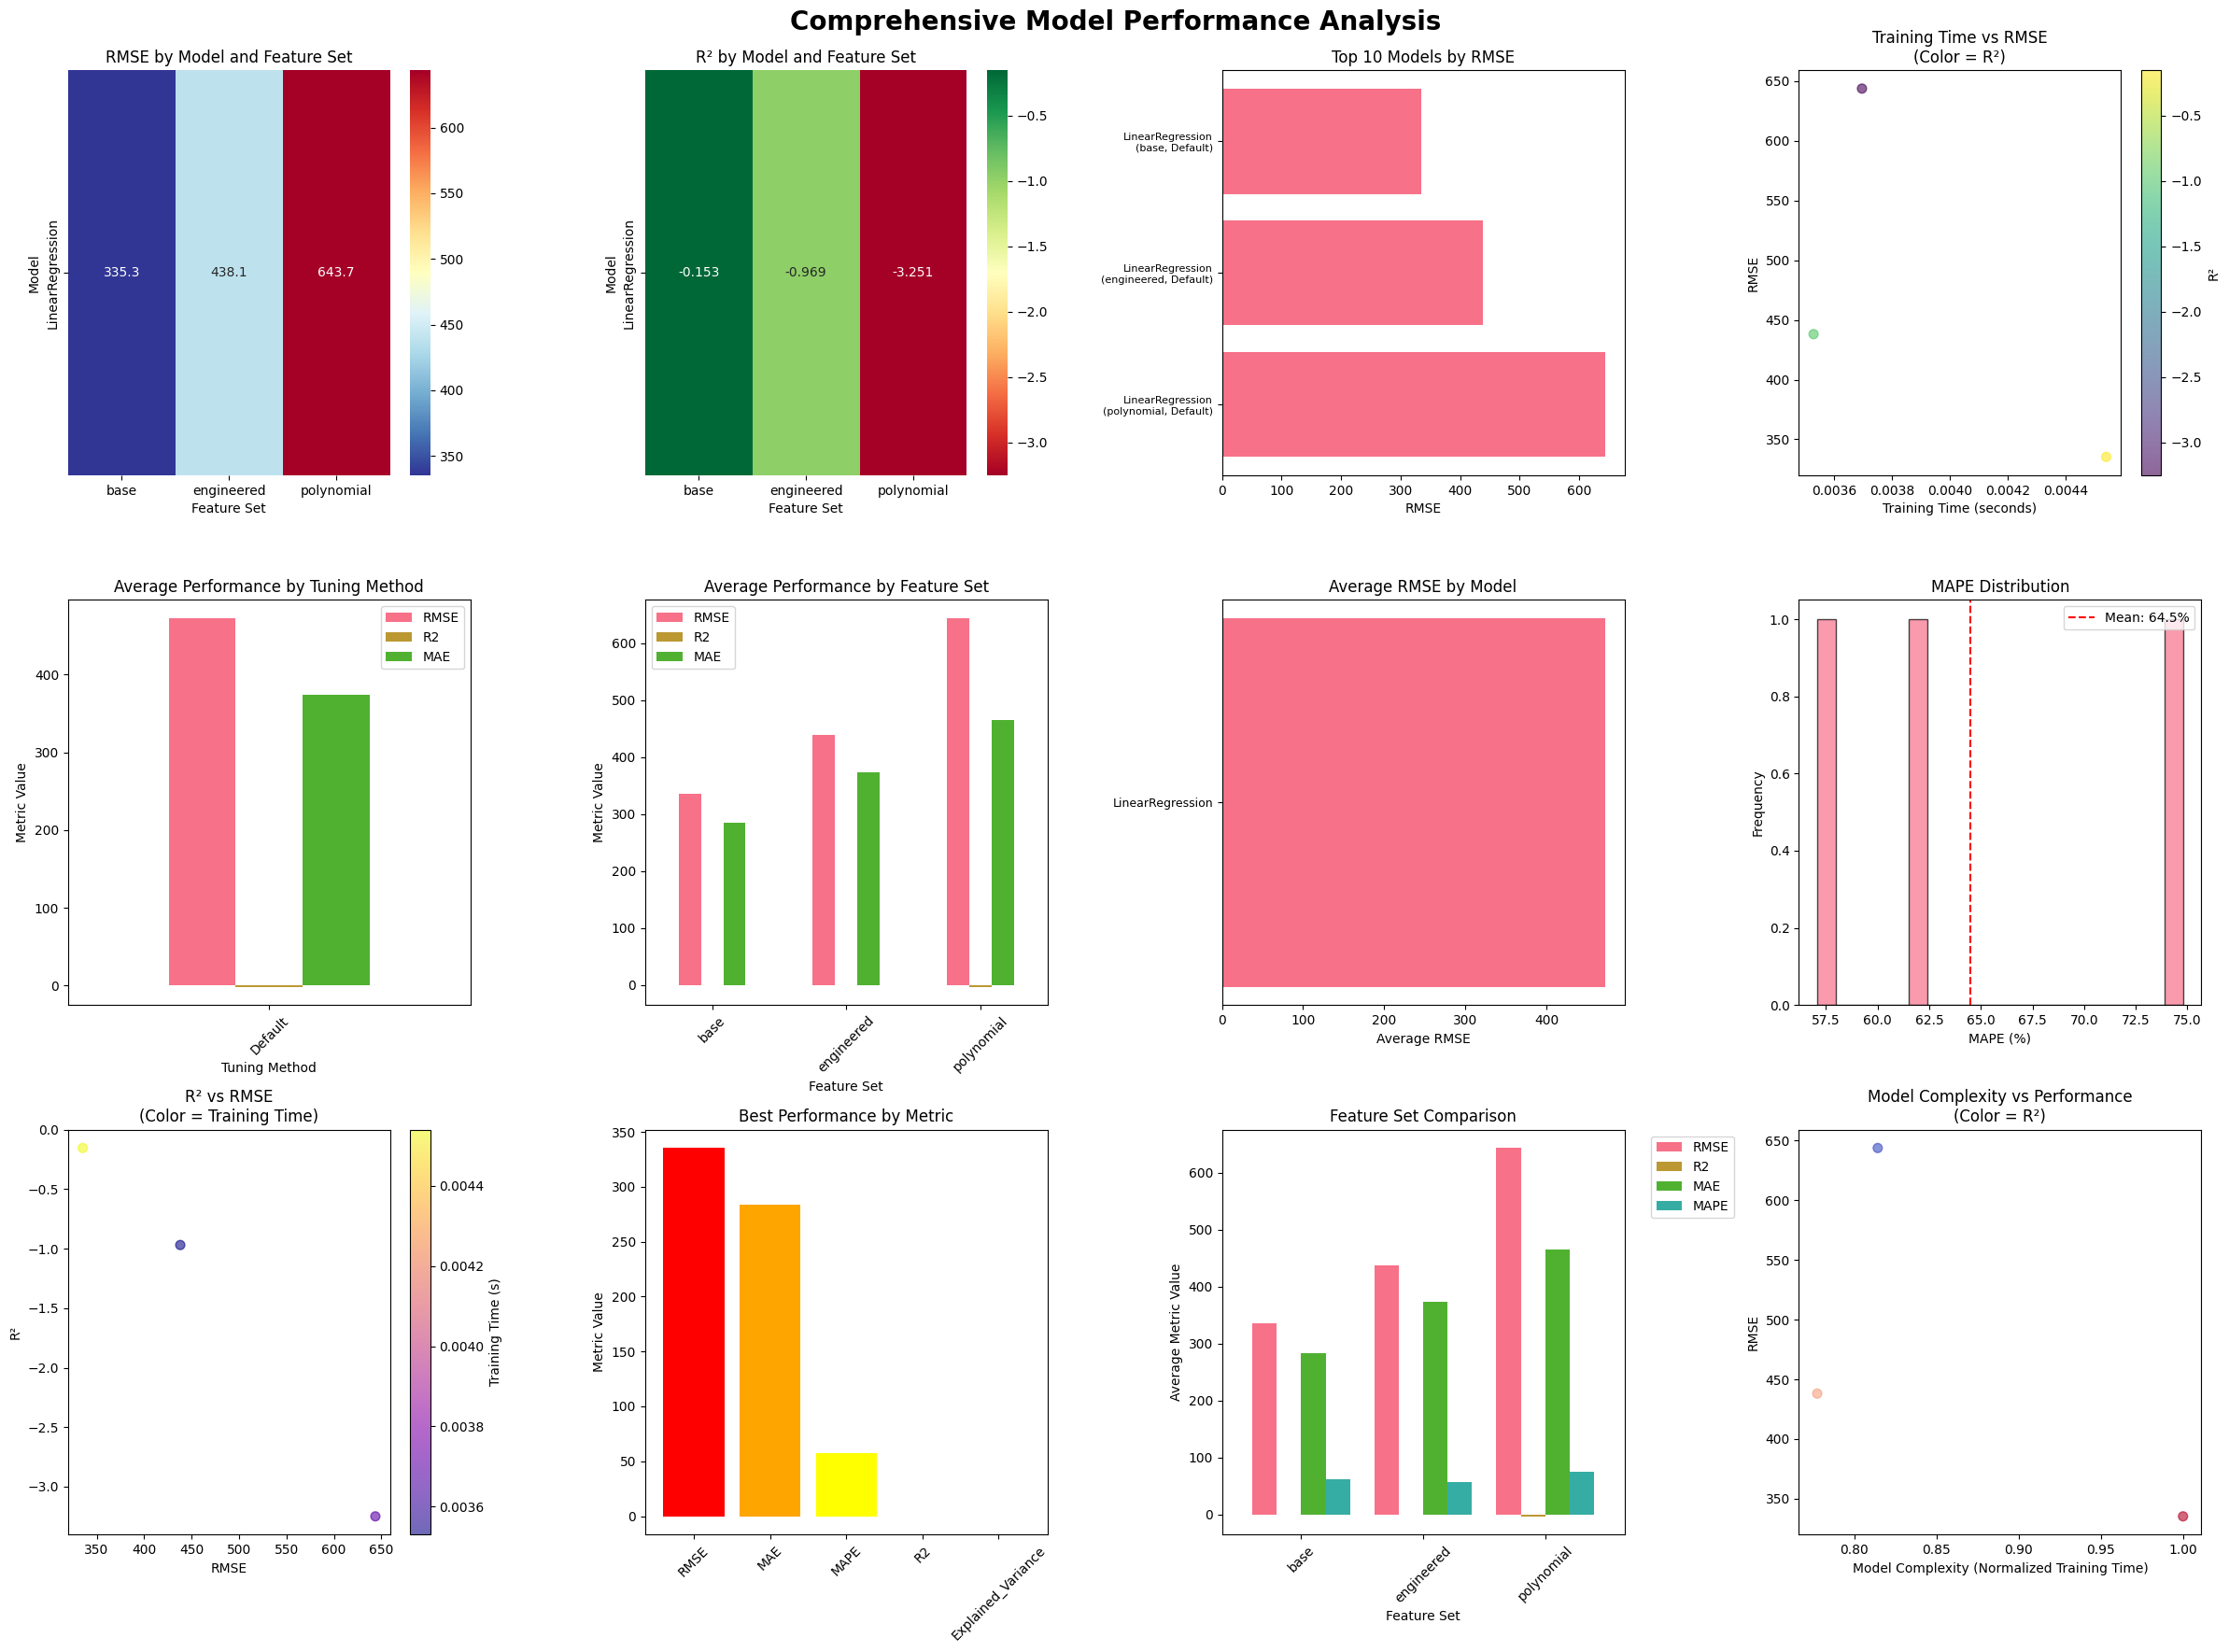

Visualizations completed successfully!


In [13]:
# Visualizations
print("=== CREATING COMPREHENSIVE VISUALIZATIONS ===")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a large figure with multiple subplots
fig = plt.figure(figsize=(24, 18))
fig.suptitle('Comprehensive Model Performance Analysis', fontsize=20, fontweight='bold', y=0.98)

# 1. RMSE Comparison by Model and Feature Set
ax1 = plt.subplot(3, 4, 1)
rmse_pivot = results_df.pivot_table(values='RMSE', index='Model', columns='Feature_Set', aggfunc='mean')
sns.heatmap(rmse_pivot, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=ax1)
ax1.set_title('RMSE by Model and Feature Set')
ax1.set_xlabel('Feature Set')
ax1.set_ylabel('Model')

# 2. R² Comparison by Model and Feature Set
ax2 = plt.subplot(3, 4, 2)
r2_pivot = results_df.pivot_table(values='R2', index='Model', columns='Feature_Set', aggfunc='mean')
sns.heatmap(r2_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax2)
ax2.set_title('R² by Model and Feature Set')
ax2.set_xlabel('Feature Set')
ax2.set_ylabel('Model')

# 3. Top 10 Models by RMSE
ax3 = plt.subplot(3, 4, 3)
top_10_models = results_sorted.head(10)
bars = ax3.barh(range(len(top_10_models)), top_10_models['RMSE'])
ax3.set_yticks(range(len(top_10_models)))
ax3.set_yticklabels([f"{row['Model']}\n({row['Feature_Set']}, {row['Tuning_Method']})" 
                     for _, row in top_10_models.iterrows()], fontsize=8)
ax3.set_xlabel('RMSE')
ax3.set_title('Top 10 Models by RMSE')
ax3.invert_yaxis()

# 4. Training Time vs Performance
ax4 = plt.subplot(3, 4, 4)
scatter = ax4.scatter(results_df['Training_Time'], results_df['RMSE'], 
                     c=results_df['R2'], cmap='viridis', alpha=0.6, s=50)
ax4.set_xlabel('Training Time (seconds)')
ax4.set_ylabel('RMSE')
ax4.set_title('Training Time vs RMSE\n(Color = R²)')
plt.colorbar(scatter, ax=ax4, label='R²')

# 5. Performance by Tuning Method
ax5 = plt.subplot(3, 4, 5)
tuning_metrics = results_df.groupby('Tuning_Method')[['RMSE', 'R2', 'MAE']].mean()
tuning_metrics.plot(kind='bar', ax=ax5)
ax5.set_title('Average Performance by Tuning Method')
ax5.set_xlabel('Tuning Method')
ax5.set_ylabel('Metric Value')
ax5.legend()
ax5.tick_params(axis='x', rotation=45)

# 6. Performance by Feature Set
ax6 = plt.subplot(3, 4, 6)
feature_metrics = results_df.groupby('Feature_Set')[['RMSE', 'R2', 'MAE']].mean()
feature_metrics.plot(kind='bar', ax=ax6)
ax6.set_title('Average Performance by Feature Set')
ax6.set_xlabel('Feature Set')
ax6.set_ylabel('Metric Value')
ax6.legend()
ax6.tick_params(axis='x', rotation=45)

# 7. Model Performance Distribution
ax7 = plt.subplot(3, 4, 7)
model_rmse = results_df.groupby('Model')['RMSE'].mean().sort_values()
ax7.barh(range(len(model_rmse)), model_rmse.values)
ax7.set_yticks(range(len(model_rmse)))
ax7.set_yticklabels(model_rmse.index, fontsize=9)
ax7.set_xlabel('Average RMSE')
ax7.set_title('Average RMSE by Model')
ax7.invert_yaxis()

# 8. MAPE Distribution
ax8 = plt.subplot(3, 4, 8)
ax8.hist(results_df['MAPE'], bins=20, alpha=0.7, edgecolor='black')
ax8.set_xlabel('MAPE (%)')
ax8.set_ylabel('Frequency')
ax8.set_title('MAPE Distribution')
ax8.axvline(results_df['MAPE'].mean(), color='red', linestyle='--', 
           label=f'Mean: {results_df["MAPE"].mean():.1f}%')
ax8.legend()

# 9. R² vs RMSE Scatter
ax9 = plt.subplot(3, 4, 9)
scatter = ax9.scatter(results_df['RMSE'], results_df['R2'], 
                     c=results_df['Training_Time'], cmap='plasma', alpha=0.6, s=50)
ax9.set_xlabel('RMSE')
ax9.set_ylabel('R²')
ax9.set_title('R² vs RMSE\n(Color = Training Time)')
plt.colorbar(scatter, ax=ax9, label='Training Time (s)')

# 10. Best Model Performance by Metric
ax10 = plt.subplot(3, 4, 10)
best_metrics = ['RMSE', 'MAE', 'MAPE', 'R2', 'Explained_Variance']
best_values = []
for metric in best_metrics:
    if metric in ['RMSE', 'MAE', 'MAPE']:
        best_idx = results_df[metric].idxmin()
    else:
        best_idx = results_df[metric].idxmax()
    best_values.append(results_df.loc[best_idx, metric])

bars = ax10.bar(best_metrics, best_values, color=['red', 'orange', 'yellow', 'green', 'blue'])
ax10.set_title('Best Performance by Metric')
ax10.set_ylabel('Metric Value')
ax10.tick_params(axis='x', rotation=45)

# 11. Feature Set Comparison
ax11 = plt.subplot(3, 4, 11)
feature_comparison = results_df.groupby('Feature_Set')[['RMSE', 'R2', 'MAE', 'MAPE']].mean()
feature_comparison.plot(kind='bar', ax=ax11, width=0.8)
ax11.set_title('Feature Set Comparison')
ax11.set_xlabel('Feature Set')
ax11.set_ylabel('Average Metric Value')
ax11.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax11.tick_params(axis='x', rotation=45)

# 12. Model Complexity vs Performance
ax12 = plt.subplot(3, 4, 12)
# Create a complexity score based on training time
complexity_score = results_df['Training_Time'] / results_df['Training_Time'].max()
ax12.scatter(complexity_score, results_df['RMSE'], 
            c=results_df['R2'], cmap='coolwarm', alpha=0.6, s=50)
ax12.set_xlabel('Model Complexity (Normalized Training Time)')
ax12.set_ylabel('RMSE')
ax12.set_title('Model Complexity vs Performance\n(Color = R²)')

plt.tight_layout()
plt.show()

print("Visualizations completed successfully!")


=== BEST MODEL DEEP DIVE ANALYSIS ===
Analyzing best model: LinearRegression
Feature set: base
Tuning method: Default

Best parameters: Default

=== COEFFICIENT ANALYSIS ===
Top 10 Most Important Features (by coefficient magnitude):
Wind_Speed               : 64.1678
Min_Temp                 : -40.6736
Population_Millions      : 39.6008
Season_encoded           : -26.9345
Humidity                 : 4.4013
Max_Temp                 : -0.2016


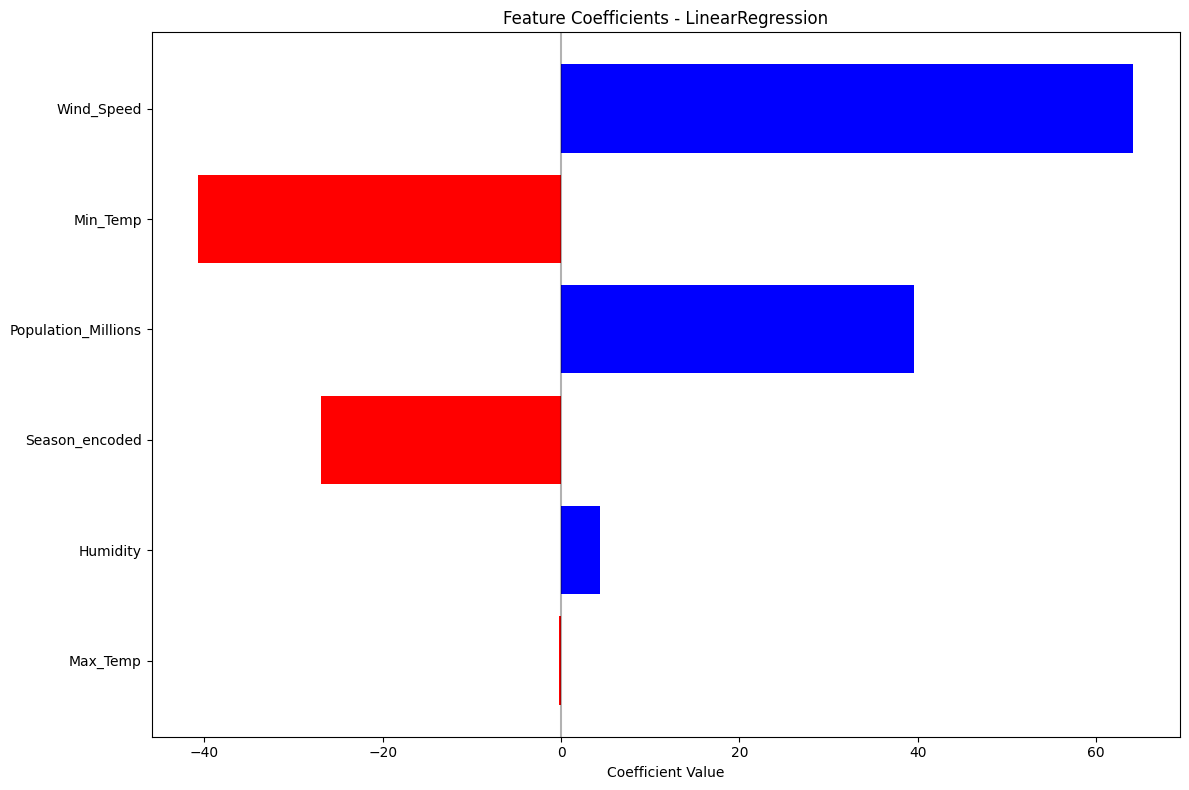


=== ACTUAL VS PREDICTED ANALYSIS ===


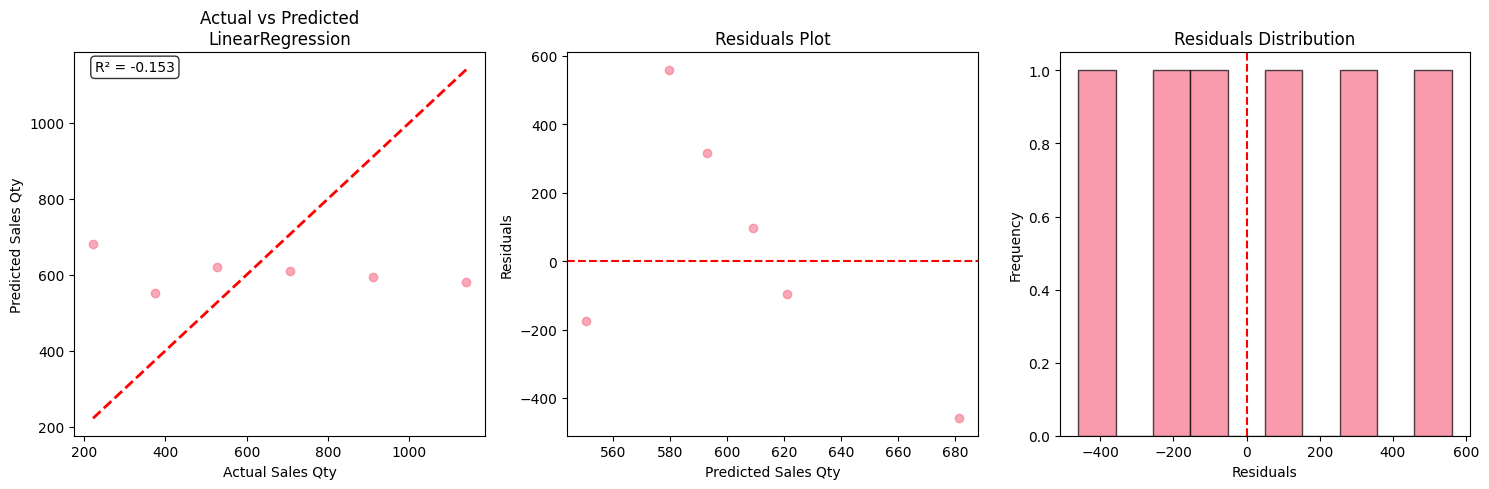


=== DETAILED PERFORMANCE METRICS ===
RMSE: 335.288
MAE: 284.005
R2: -0.153
MAPE: 61.6%
MedAE: 246.156
Max_Error: 560.211
Explained_Variance: -0.136

=== PREDICTION ACCURACY BY SALES RANGE ===
Low    Sales: MAE = 243.4, MAPE = 90.6%
Medium Sales: MAE = 96.8, MAPE = 13.7%
High   Sales: MAE = 438.5, MAPE = 42.0%


In [14]:
# Best Model Analysis and Feature Importance
print("=== BEST MODEL DEEP DIVE ANALYSIS ===")

# Get the best model configuration
best_model_name = best_model['Model']
best_feature_set = best_model['Feature_Set']
best_tuning_method = best_model['Tuning_Method']

print(f"Analyzing best model: {best_model_name}")
print(f"Feature set: {best_feature_set}")
print(f"Tuning method: {best_tuning_method}")

# Retrain the best model to get feature importance and detailed analysis
best_model_config = models_config[best_model_name]
best_model_instance = best_model_config['model']

# Get the appropriate feature set
X_train_best, X_test_best, feature_names_best = feature_sets[best_feature_set]

# Retrain with best parameters
if best_tuning_method == 'Default':
    final_model = best_model_instance.__class__(**best_model_instance.get_params())
    final_model.fit(X_train_best, y_train)
    best_params = 'Default'
    
elif best_tuning_method == 'GridSearch':
    grid_search = GridSearchCV(
        best_model_instance, best_model_config['grid_params'], 
        cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE
    )
    grid_search.fit(X_train_best, y_train)
    final_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
elif best_tuning_method == 'RandomSearch':
    random_search = RandomizedSearchCV(
        best_model_instance, best_model_config['random_params'], 
        n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE
    )
    random_search.fit(X_train_best, y_train)
    final_model = random_search.best_estimator_
    best_params = random_search.best_params_

# Generate predictions
y_pred_best = final_model.predict(X_test_best)

print(f"\nBest parameters: {best_params}")

# Feature importance analysis (for tree-based models)
if hasattr(final_model, 'feature_importances_'):
    print(f"\n=== FEATURE IMPORTANCE ANALYSIS ===")
    feature_importance = pd.DataFrame({
        'feature': feature_names_best,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"{row['feature']:25s}: {row['importance']:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif hasattr(final_model, 'coef_'):
    print(f"\n=== COEFFICIENT ANALYSIS ===")
    if len(final_model.coef_.shape) == 1:
        coefficients = pd.DataFrame({
            'feature': feature_names_best,
            'coefficient': final_model.coef_
        }).sort_values('coefficient', key=abs, ascending=False)
        
        print("Top 10 Most Important Features (by coefficient magnitude):")
        for idx, row in coefficients.head(10).iterrows():
            print(f"{row['feature']:25s}: {row['coefficient']:.4f}")
        
        # Plot coefficients
        plt.figure(figsize=(12, 8))
        top_coefs = coefficients.head(15)
        colors = ['red' if x < 0 else 'blue' for x in top_coefs['coefficient']]
        plt.barh(range(len(top_coefs)), top_coefs['coefficient'], color=colors)
        plt.yticks(range(len(top_coefs)), top_coefs['feature'])
        plt.xlabel('Coefficient Value')
        plt.title(f'Feature Coefficients - {best_model_name}')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

# Actual vs Predicted Analysis
print(f"\n=== ACTUAL VS PREDICTED ANALYSIS ===")
plt.figure(figsize=(15, 5))

# 1. Actual vs Predicted Scatter Plot
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales Qty')
plt.ylabel('Predicted Sales Qty')
plt.title(f'Actual vs Predicted\n{best_model_name}')

# Add R² to the plot
r2_best = r2_score(y_test, y_pred_best)
plt.text(0.05, 0.95, f'R² = {r2_best:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Residuals Plot
plt.subplot(1, 3, 2)
residuals = y_test - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Sales Qty')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# 3. Residuals Distribution
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=10, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# Detailed performance metrics
print(f"\n=== DETAILED PERFORMANCE METRICS ===")
detailed_metrics = calculate_metrics(y_test, y_pred_best)
for metric, value in detailed_metrics.items():
    if metric == 'MAPE':
        print(f"{metric}: {value:.1f}%")
    else:
        print(f"{metric}: {value:.3f}")

# Prediction accuracy by range
print(f"\n=== PREDICTION ACCURACY BY SALES RANGE ===")
test_ranges = pd.cut(y_test, bins=3, labels=['Low', 'Medium', 'High'])
range_accuracy = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_best,
    'Range': test_ranges
})

for range_name in ['Low', 'Medium', 'High']:
    range_data = range_accuracy[range_accuracy['Range'] == range_name]
    if len(range_data) > 0:
        range_mae = mean_absolute_error(range_data['Actual'], range_data['Predicted'])
        range_mape = np.mean(np.abs((range_data['Actual'] - range_data['Predicted']) / 
                                   np.maximum(np.abs(range_data['Actual']), 1e-8))) * 100
        print(f"{range_name:6s} Sales: MAE = {range_mae:.1f}, MAPE = {range_mape:.1f}%")


In [15]:
# Final Predictions and Summary
print("=== FINAL PREDICTIONS AND SUMMARY ===")

# Create comprehensive predictions table
predictions_df = pd.DataFrame({
    'YearMonth': test_eng['YearMonth'],
    'Actual_Sales_Qty': y_test,
    'Predicted_Sales_Qty': y_pred_best,
    'Error': y_test - y_pred_best,
    'Absolute_Error': np.abs(y_test - y_pred_best),
    'Percentage_Error': ((y_test - y_pred_best) / np.maximum(np.abs(y_test), 1e-8)) * 100
})

print("=== FINAL PREDICTIONS ON TEST SET ===")
print(predictions_df.round(2))

# Summary statistics
print(f"\n=== PREDICTION SUMMARY STATISTICS ===")
print(f"Mean Absolute Error: {predictions_df['Absolute_Error'].mean():.2f}")
print(f"Mean Absolute Percentage Error: {predictions_df['Percentage_Error'].abs().mean():.1f}%")
print(f"Root Mean Square Error: {np.sqrt(np.mean(predictions_df['Error']**2)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_best):.3f}")

# Best and worst predictions
print(f"\n=== BEST AND WORST PREDICTIONS ===")
best_pred_idx = predictions_df['Absolute_Error'].abs().idxmin()
worst_pred_idx = predictions_df['Absolute_Error'].abs().idxmax()

print(f"Best prediction (smallest error):")
print(f"  Date: {predictions_df.loc[best_pred_idx, 'YearMonth']}")
print(f"  Actual: {predictions_df.loc[best_pred_idx, 'Actual_Sales_Qty']:.1f}")
print(f"  Predicted: {predictions_df.loc[best_pred_idx, 'Predicted_Sales_Qty']:.1f}")
print(f"  Error: {predictions_df.loc[best_pred_idx, 'Error']:.1f}")

print(f"\nWorst prediction (largest error):")
print(f"  Date: {predictions_df.loc[worst_pred_idx, 'YearMonth']}")
print(f"  Actual: {predictions_df.loc[worst_pred_idx, 'Actual_Sales_Qty']:.1f}")
print(f"  Predicted: {predictions_df.loc[worst_pred_idx, 'Predicted_Sales_Qty']:.1f}")
print(f"  Error: {predictions_df.loc[worst_pred_idx, 'Error']:.1f}")

# Save results to CSV
results_df.to_csv('regression_model_results.csv', index=False)
predictions_df.to_csv('final_predictions.csv', index=False)

print(f"\n=== RESULTS SAVED ===")
print(f"Model comparison results saved to: regression_model_results.csv")
print(f"Final predictions saved to: final_predictions.csv")

# Final model summary
print(f"\n=== FINAL MODEL SUMMARY ===")
print(f"Best Model: {best_model_name}")
print(f"Feature Set: {best_feature_set}")
print(f"Tuning Method: {best_tuning_method}")
print(f"Best Parameters: {best_params}")
print(f"Test Set Performance:")
print(f"  RMSE: {detailed_metrics['RMSE']:.2f}")
print(f"  MAE: {detailed_metrics['MAE']:.2f}")
print(f"  R²: {detailed_metrics['R2']:.3f}")
print(f"  MAPE: {detailed_metrics['MAPE']:.1f}%")
print(f"  Explained Variance: {detailed_metrics['Explained_Variance']:.3f}")

# Model recommendations
print(f"\n=== MODEL RECOMMENDATIONS ===")
print(f"1. Best Overall Model: {best_model_name} with {best_feature_set} features")
print(f"2. Best R² Score: {best_r2['Model']} ({best_r2['Feature_Set']}, {best_r2['Tuning_Method']}) - R²: {best_r2['R2']:.3f}")
print(f"3. Fastest Training: {fastest['Model']} ({fastest['Feature_Set']}, {fastest['Tuning_Method']}) - Time: {fastest['Training_Time']:.2f}s")
print(f"4. Most Accurate (Lowest MAPE): {best_mape['Model']} ({best_mape['Feature_Set']}, {best_mape['Tuning_Method']}) - MAPE: {best_mape['MAPE']:.1f}%")

# Feature engineering insights
print(f"\n=== FEATURE ENGINEERING INSIGHTS ===")
feature_performance_sorted = feature_performance.sort_values('RMSE')
print("Feature set performance (best to worst by RMSE):")
for idx, (feature_set, metrics) in enumerate(feature_performance_sorted.iterrows(), 1):
    print(f"{idx}. {feature_set}: RMSE={metrics['RMSE']:.2f}, R²={metrics['R2']:.3f}")

# Hyperparameter tuning insights
print(f"\n=== HYPERPARAMETER TUNING INSIGHTS ===")
tuning_performance_sorted = tuning_performance.sort_values('RMSE')
print("Tuning method performance (best to worst by RMSE):")
for idx, (tuning_method, metrics) in enumerate(tuning_performance_sorted.iterrows(), 1):
    print(f"{idx}. {tuning_method}: RMSE={metrics['RMSE']:.2f}, R²={metrics['R2']:.3f}, Time={metrics['Training_Time']:.2f}s")

print(f"\n{'='*80}")
print(f"REGRESSION ANALYSIS COMPLETED SUCCESSFULLY!")
print(f"{'='*80}")
print(f"Total models tested: {len(models_config)}")
print(f"Total experiments: {len(results_df)}")
print(f"Best model: {best_model_name}")
print(f"Best performance: RMSE={detailed_metrics['RMSE']:.2f}, R²={detailed_metrics['R2']:.3f}")
print(f"{'='*80}")


=== FINAL PREDICTIONS AND SUMMARY ===
=== FINAL PREDICTIONS ON TEST SET ===
   YearMonth  Actual_Sales_Qty  Predicted_Sales_Qty   Error  Absolute_Error  \
0 2025-01-01             706.0               609.16   96.84           96.84   
1 2025-02-01             375.0               550.53 -175.53          175.53   
2 2025-03-01            1140.0               579.79  560.21          560.21   
3 2025-04-01             910.0               593.22  316.78          316.78   
4 2025-05-01             526.0               621.25  -95.25           95.25   
5 2025-06-01             222.0               681.41 -459.41          459.41   

   Percentage_Error  
0             13.72  
1            -46.81  
2             49.14  
3             34.81  
4            -18.11  
5           -206.94  

=== PREDICTION SUMMARY STATISTICS ===
Mean Absolute Error: 284.01
Mean Absolute Percentage Error: 61.6%
Root Mean Square Error: 335.29
R² Score: -0.153

=== BEST AND WORST PREDICTIONS ===
Best prediction (smallest e